**Project 1 Phase 2**<br>
Group 8
<br>
<table style="width:100%">
  <tr>
    <th style = "text-align: left">#</th>
    <th style = "text-align: left">Name</th>
    <th style = "text-align: left">Lastname</th>
    <th style = "text-align: left">Matr Number</th>
  </tr>
  <tr>
    <td style = "text-align: left">1</td>
    <td style = "text-align: left">Christian</td>
    <td style = "text-align: left">Peinthor</td>
    <td style = "text-align: left">11815592</td>
  </tr>
  <tr>
    <td style = "text-align: left">2</td>
    <td style = "text-align: left">Michael</td>
    <td style = "text-align: left">Weikl</td>
    <td style = "text-align: left">1154652</td>
  </tr>
  <tr>
    <td style = "text-align: left">3</td>
    <td style = "text-align: left">Uros</td>
    <td style = "text-align: left">Zivanovic</td>
    <td style = "text-align: left">12032271</td>
  </tr>
  <tr>
    <td style = "text-align: left">4</td>
    <td style = "text-align: left">Maximilian</td>
    <td style = "text-align: left">Hofmann</td>
    <td style = "text-align: left">12019987</td>
  </tr>
  
</table>
<br>

**Attempted improvements: All except 2 and 6.**

Some are explicitly defined functions (stopping criterion, derivation...), others are implemented within their respective algorithms.

# Table of contents
* [Problemdefinition](#Problemdefinition)
* [Basic functions](#Basic-functions)
    * [Stopping Criterion](#Stopping-Criterion)
    * [Backtracking](#Backtracking)
    * [Wolfe Condition](#Wolfe-Condition)
    * [Derivation (Taylor-Theorem)](Derivation-(Taylor-Theorem))
* [Implementation of the algorithms](#Implementation-of-the-algorithms)
    * [Steepest descent](#Steepest-descent)
    * [Newthon method](#Newthon-method)
    * [Fetcher Reeves](#Fetcher-Reeves)
    * [SR1](#SR1)
* [Executions](#Executions)


In [1]:
import numpy as np
import scipy 
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from numpy.linalg import *

# Problem Definitions

Basic Problem class to set up problems for the algorithms to be solved.

In [2]:
class Problem():
    def f(self, x):
        raise NotImplementedError("f() is not implemented for this Problem")
    
    def grad_f(self, x):
        raise NotImplementedError("grad_f() is not implemented for this Problem")
            
    def hessian(self, x):
        raise NotImplementedError("hessian() is not implemented for this Problem")      
        

## Polynomials

In [3]:
class PolynomialProblem(Problem):
        @property
        def actual_minima(self):
            raise NotImplementedError("actual_minima() is not implemented for this Problem")      


############################################################
#                Polynomial definitions
############################################################

class Rosenbrock(PolynomialProblem):
    def f(self, x):
        return 100*(x[1] - x[0]**2)**2 + (1 - x[0])**2

    def grad_f(self, x):
        return np.array([-400*x[0]*(x[1] - x[0]**2) - 2*(1 - x[0]),
                         200*(x[1] - x[0]**2)])

    def hessian(self, x):
        return np.array([[-400*(x[1] - 3*x[0]**2) + 2, 
                          -400*x[0]],
                         [-400*x[0], 
                          200]])
    
    @property
    def actual_minima(self):
        return np.array([1,1])


#this is the function below rosenbrock defined in the project description
class Function2(PolynomialProblem):
    def f(self, x):
        return 150*(x[0] * x[1])**2 + (0.5 * x[0] + 2 * x[1] - 2)**2
    
    def grad_f(self, x):
        return np.array([x[0] * (300 * x[1]**2 + 0.5) + 2 * x[1] - 2, 300*x[0]**2 * x[1] + 2 * x[0] + 8 * x[1] - 8])

    def hessian(self, x):
        return np.array([[300 * x[1]**2 + 0.5, 600 * x[0]*x[1] + 2],[600 * x[0]*x[1] + 2, 300 * x[0]**2 + 8]])

    #self calculated minima
    @property
    def actual_minima(self):
        return np.array([[0,1],[4,0]])

## Squared Error

In [4]:
# Helper functions for squared error problems
def normal_distributed_data_points(target_function, q: float, num_points: int):
    # bring normal distributed value from range [0, 1] to  [-q, q]
    return distributed_data_points(target_function=target_function, q=q, num_points=num_points,
                                   distribution=lambda r: (np.random.normal(0, scale=2 * r) - r))


def uniform_distributed_data_points(target_function, q: float, num_points: int):
    return distributed_data_points(target_function=target_function, q=q, num_points=num_points,
                                   distribution=lambda r: np.random.uniform(low=-r, high=r))


def distributed_data_points(target_function, q: float, num_points: int, distribution):
    result_list = []

    for _ in range(num_points):
        val = distribution(abs(q))
        result_list.append((val, target_function(val)))

    return result_list

In [5]:
class SquaredErrorProblem(Problem):
    def __init__(self, target_function,
                 q: int = 2, num_points: int = 100, degree: int = 5,
                 random_seed: int = 1154652, distribution='uniform'):
        if distribution == 'uniform':
            self.data = uniform_distributed_data_points(target_function=target_function, q=q, num_points=num_points)
        elif distribution == 'normal':
            self.data = normal_distributed_data_points(target_function=target_function, q=q, num_points=num_points)
        else:
            raise NotImplementedError(
                f"Functionality not implemented for ditribution type '{distribution}'. Use 'uniform' or 'normal'.")

        self.coefficients = []
        for j in range(num_points):
            a_j = self.data[j][0]
            c_j = np.reshape([a_j ** i for i in range(degree + 1)], (degree + 1, 1))
            self.coefficients.append(c_j)

        self.target_function = target_function
    
    def __residual(self, x):
        c = np.squeeze(np.array(self.coefficients))
        b = np.reshape(np.array([v for _, v in self.data]), (len(self.data), 1))

        return (c @ x) - b

    def f(self, x):
        r = self.__residual(x)
        return 1 / 2 * np.sum(r ** 2)

    def grad_f(self, x):
        r = self.__residual(x)
        c = np.squeeze(np.array(self.coefficients))
        return (r.T @ c).T

    def hessian(self, x):
        c = np.squeeze(np.array(self.coefficients))
        return (c.T @ c).T
#     def __residual(self, x, j):
#         a_j = self.data[j][0]
#         b_j = self.data[j][1]
#         c_j = self.coefficients[j]

#         return c_j.T @ x - b_j

#     def f(self, x):
#         return 1 / 2 * np.sum([self.__residual(x, j) ** 2 for j in range(len(self.data))])

#     def grad_f(self, x):
#         return np.sum([self.__residual(x, j) * self.coefficients[j] for j in range(len(self.data))], axis=0)

#     def hessian(self, x):
#         return np.sum([self.coefficients[j] @ self.coefficients[j].T for j in range(len(self.data))], axis=0)


############################################################
#              Squared Error Problem Definition
############################################################

class SinusSQEP(SquaredErrorProblem):
    def __init__(self, q: int = 2, num_points: int = 100, degree: int = 5,
                 random_seed: int = 1154652, distribution='uniform'):
        super().__init__(lambda x: np.sin(x), q, num_points, degree, random_seed, distribution)


class CosinusSQEP(SquaredErrorProblem):
    def __init__(self, q: int = 2, num_points: int = 100, degree: int = 5,
                 random_seed: int = 1154652, distribution='uniform'):
        super().__init__(lambda x: np.cos(x), q, num_points, degree, random_seed, distribution)


class SinusMinusCosinusSQEP(SquaredErrorProblem):
    def __init__(self, q: int = 2, num_points: int = 100, degree: int = 5,
                 random_seed: int = 1154652, distribution='uniform'):
        super().__init__(lambda x: np.sin(x) - np.cos(x), q, num_points, degree, random_seed, distribution)


class CubePlusSquareSQEP(SquaredErrorProblem):
    def __init__(self, q: int = 2, num_points: int = 100, degree: int = 5,
                 random_seed: int = 1154652, distribution='uniform'):
        super().__init__(lambda x: x ** 3 + x ** 2, q, num_points, degree, random_seed, distribution)


class SinusPlusCosinusSQEP(SquaredErrorProblem):
    def __init__(self, q: int = 2, num_points: int = 100, degree: int = 5,
                 random_seed: int = 1154652, distribution='uniform'):
        super().__init__(lambda x: 3 * np.sin(x) + np.cos(x), q, num_points, degree, random_seed, distribution)

# Basic functions

## Stopping Criterion

This implements a stopping criterion for when the gradient of f at xk is small relative to the gradient of f at x0
Also a maxmimum number of iterations is implemented.

In [6]:
def stop_crit(grad_f, xk, x0, current_iteration, tol: float = 1e-8, max_iter: int = 1000):
    if current_iteration > max_iter:
        return True
    elif norm(grad_f(xk)) <= tol * norm(grad_f(x0)):
        return True
    return False

## Backtracking

Backtracking linesearch to find suitable step length as described in the book. steepest_descent() implements the line search steepest descent method.

In [7]:
def backtracking_alpha(f, grad_f, xk, pk, alpha0=1, rho=0.95, c=1e-4):
    alpha = alpha0
    f_xk = f(xk)
    grad_f_xk = grad_f(xk)

    while f(xk + alpha * pk) > (f_xk + c * alpha * grad_f_xk.T @ pk):
        alpha *= rho

    return alpha

## Wolfe Condition

alpha_wolfe() returns a step length satisfiying the weak wolfe conditions using a bisection approach as described in https://sites.math.washington.edu/~burke/crs/408/notes/nlp/line.pdf.

In [8]:
def alpha_wolfe(f, grad_f, xk, pk, c1=1e-4, c2=0.9):
    alpha = 0
    beta = np.Inf
    t = 1

    while True:
        grad_calc = grad_f(xk)
        if f(xk + t * pk) > (f(xk) + c1 * t * (pk.T @ grad_calc)):
            beta = t
            t = 0.5 * (alpha + beta)
        elif (-pk.T @ grad_f(xk + t * pk)) > (-c2 * pk.T @ grad_calc):
            alpha = t
            t = (2 * alpha if beta == np.Inf else 0.5 * (alpha + beta))
        else:
            return t

## Derivation (Taylor Theorem)

This implements the forward difference approach from the book for gradient and hessian calculation without explicit function knowledge.

In [9]:
def e_i(size, index):
    arr = np.zeros(size)
    arr[index] = 1.0
    return arr


# these return the function that computes the gradient, which can then in turn be called to compute the gradient
def approx_grad(f, e=1.1e-8):
    def grad_f(x):
        if x.size == 1:
            return (f(x + e) - f(x)) / e
        return np.array([(f(x + e * e_i(x.size, i)) - f(x)) / e for i in range(x.size)])

    return grad_f


def approx_hessian(f, e=1.1e-8):
    def hessian_f(x):
        if x.size == 1:
            return (f(x + 2 * e) - 2 * f(x + e) + f(x)) / e ** 2
        return np.array([[(f(x + e * e_i(x.size, i) + e * e_i(x.size, j)) - f(
            x + e * e_i(x.size, i)) - f(x + e * e_i(x.size, j)) + f(
            x)) / e ** 2 for j in range(x.size)] for i in range(x.size)])

    return hessian_f

# Implementation of the algorithms

## Steepest descent

In [10]:
def steepest_descent(x0, f, grad_f=None, initial_alpha: float = 1e-3, tolerance: float = 1e-8):
    if grad_f == None:
        grad_f = approx_grad(f)

    i = 0
    xk = x0
    search_alpha, alpha, pk = None, None, None

    while not stop_crit(grad_f, xk, x0, i, tol=tolerance, max_iter=5000):

        if search_alpha is None:
            search_alpha = initial_alpha
            pk = -grad_f(xk)
        else:
            new_pk = -grad_f(xk)
            search_alpha = alpha * (-pk.T @ pk) / (-new_pk.T @ new_pk)
            pk = new_pk

        alpha = backtracking_alpha(f, grad_f, xk, pk)
        xk = xk + alpha * pk

        i += 1

    return xk, i

## Newton method

newton_method() implements the line search Newton method solving the equation H @ pk = -grad instead of computing the inverse of H.

In [11]:
def newton_method(x0, f, grad_f=None, hessian_f=None, tolerance=1e-8):
    if grad_f == None:
        grad_f = approx_grad(f)
        hessian_f = approx_hessian(f)
    i = 0
    x = x0

    while not stop_crit(grad_f, x, x0, i, tol=tolerance):
        pk = np.array([- (1 / hessian_f(x)) @ grad_f(x)]) if x.size == 1 else solve(hessian_f(x), -grad_f(x))
        x = x + alpha_wolfe(f, grad_f, x, pk) * pk
        i += 1

    #print(f"\n Search terminated after iteration {i} with result: {x}")
    return x, i

## Fletcher Reeves

Implementation of the Fletcher Reeves nonlinear conjugate gradient method.

In [12]:
def FR(x0, f, grad_f=None, tolerance=1e-8):

    if grad_f == None:
        grad_f = approx_grad(f)
    i = 0
    xk = x0
    pk = -grad_f(xk)

    while not stop_crit(grad_f, xk, x0, i, tol=tolerance, max_iter=5000):

        xk1 = xk + backtracking_alpha(f, grad_f, xk, pk) * pk
        beta = (grad_f(xk1).T @ grad_f(xk1)) / (grad_f(xk).T @ grad_f(xk))
        pk = -grad_f(xk1) + beta * pk
        xk = xk1
        i += 1
 
    #print(f"\n Search terminated after iteration {i} with result: {xk}")
    return xk, i

## BFGS

For some reason our BFGS implementation did not work here in our collaborative notebook. We excluded it from the done calculations but kept it in in case we would find the error or it magically starting to work when we are done tinkering with everything else.

In [13]:
def approx_hessian_bfgs(f_grad, B_k, x_1, x):
    """
    Approximate Hessian based on first derivitive using previous values.
    :param f_grad: first derivitive of f
    :param B_k: current hessian
    :param x_1: x_{k+1}
    :param x: x_{k}
    :return: approximated hessian
    """

    s_k = x_1 - x
    y_k = f_grad(x_1) - f_grad(x)

    return B_k - (B_k * s_k * np.transpose(s_k) * B_k) / \
           (np.transpose(s_k) * B_k * s_k) + \
           (y_k * np.transpose(y_k)) / (np.transpose(y_k) * s_k)


def BFGS(x0, f, grad_f=None, tolerance=1e-8):
    iterations = 1000
    tolerance = tolerance
    if grad_f is None:
        f_prime = approx_grad(f)
    else:
        f_prime = grad_f

    H = np.eye(x0.shape[0])
    x = x0
    i = 0

    for i in range(iterations):
        f_x = f_prime(x)

        if np.all(np.abs(f_x) < tolerance):
            return x

        x_old = np.copy(x)

        direction = -H @ f_x
        step_size = alpha_wolfe(f, f_prime, x, direction)
        x = x +  step_size * direction

        x = np.sum(x.reshape(x.shape[0], -1), 1)
        H = approx_hessian_bfgs(f_prime, H, x, x_old)

    return x, i


## SR1

SR1() implements the line search quasi newton method utilizing SR1 updating for inverse Hessian approximation and a method for stabilizing that resets H as a multiple of I inspired by the method deployed in https://www.sciencedirect.com/science/article/pii/S0898122111004202?via%3Dihub.

We limited maximum iterations to 55 for this algorithm because after that point in some cases computations got really heavy and led to very long searches without significant result improvement.

In [14]:
def SR1(x0 : np.array, f, grad_f, r=1e-8):

    if grad_f == None:
        grad_f = approx_grad(f)
    conv_tol = 1e-8
    i = 0
    H = np.identity(x0.size)
    x = x0
    
    pk = - H @ grad_f(x)
    x_1 = x + alpha_wolfe(f, grad_f, x, pk) * pk
    sk = x_1 - x
    yk = grad_f(x_1) - grad_f(x)
    
    H = (yk.T @ sk)/(yk.T @ yk) * np.identity(x0.size)
    

    while not stop_crit(grad_f, x, x0, i, tol=conv_tol, max_iter=54):
  
        pk = - H @ grad_f(x)
        x_1 = x + alpha_wolfe(f, grad_f, x, pk) * pk
        sk = x_1 - x
        yk = grad_f(x_1) - grad_f(x)
        rhok = 1 / (yk.T @ sk)
    
        if ((sk.T @ yk - yk.T @ H @ yk) < 0) or (abs(yk.T @ (sk - H @ yk)) < r * np.linalg.norm(yk) * np.linalg.norm(sk - H @ yk)) or (
            norm(H, np.inf) > 1e10):
            mu = (sk.T @ sk) / (yk.T @ sk) - ((sk.T @ sk)**2 / (yk.T @ sk)**2 - (sk.T @ sk) / (yk.T @ yk))**0.5
            H_1 = mu * np.identity(x0.size)
            H = H_1
        else:
            H_1 = H + np.outer((sk - H @ yk), (sk - H @ yk)) / ((sk - H @ yk).T @ yk)
            H = H_1
        
        x = x_1
        i += 1

    #print(f"\n Search terminated after iteration {i} with result: {x}")
    return x, i


# Executions

In [15]:
# Define list with all possible algorithms for the tests
algorithms = {'Steepest descent': steepest_descent,
              'Newthon method': newton_method,
              'Fletcher Reeves': FR,
              'SR1': SR1,
              'BFGS': BFGS}

## Rosenbrock Problems

In [16]:
algorithms_rosenbrock = {'Steepest descent': steepest_descent,
              'Newthon method': newton_method,
              'Fletcher Reeves': FR,
              'SR1': SR1}
polynomial_problems = {Rosenbrock(): [1.2,1.2], 
                       Rosenbrock(): [-1.2,1],
                       Rosenbrock(): [0,1],
                       Rosenbrock(): [-1,0],
                       Rosenbrock(): [0,-1]}

for prob, start_value in polynomial_problems.items():
    
    print("**********************************************")
    print(f"Problem {type(prob).__name__} starting point{start_value}:")
    print("**********************************************")
    for algorithm_name, algorithm in algorithms_rosenbrock.items():
        try:
            print("------------------------------------------------")
            print(f"\tAlgorithm '{algorithm_name}':")
            print("------------------------------------------------")
            parameters = {'x0': np.array(start_value),
                          'f': prob.f,
                          'grad_f': None,
                          'hessian_f': None}

            # clean up parameters for generic method call
            possible_parameters = algorithm.__code__.co_varnames
            for p in list(parameters):
                if p not in possible_parameters:
                    parameters.pop(p)

            x, iterations = algorithm(**parameters)

            print(f"Search terminated after iteration {iterations} with result: {x}")
            print(f"Last gradient norm: {norm(prob.grad_f(x))}")
            print("Difference to real solutions:")
            print(f"\tDifference to point '{prob.actual_minima}' is {norm(x - prob.actual_minima)}")
        
        except Exception as err:
            print(err)
            print(f"Algorithm '{algorithm_name}' failed to find a solution")

**********************************************
Problem Rosenbrock starting point[1.2, 1.2]:
**********************************************
------------------------------------------------
	Algorithm 'Steepest descent':
------------------------------------------------
Search terminated after iteration 5001 with result: [1.00225053 1.00455368]
Last gradient norm: 0.017391046221041075
Difference to real solutions:
	Difference to point '[1 1]' is 0.005079460238159602
------------------------------------------------
	Algorithm 'Newthon method':
------------------------------------------------
Search terminated after iteration 6 with result: [0.99999637 0.99999274]
Last gradient norm: 5.130305357442694e-06
Difference to real solutions:
	Difference to point '[1 1]' is 8.120916393507349e-06
------------------------------------------------
	Algorithm 'Fletcher Reeves':
------------------------------------------------
Search terminated after iteration 5001 with result: [0.99999851 0.99999701]
La

## Defined Function 2 Problems

In [17]:
polynomial_problems = {Function2(): [-0.2,1.2], 
                       Function2(): [3.8,0.1],
                       Function2(): [0,0],
                       Function2(): [-1,0],
                       Function2(): [0,-1]}

for prob, start_value in polynomial_problems.items():
    
    print("**********************************************")
    print(f"Problem {type(prob).__name__} starting point{start_value}:")
    print("**********************************************")
    for algorithm_name, algorithm in algorithms_rosenbrock.items():
        try:
            print("------------------------------------------------")
            print(f"\tAlgorithm '{algorithm_name}':")
            print("------------------------------------------------")
            parameters = {'x0': np.array(start_value),
                          'f': prob.f,
                          'grad_f': None,
                          'hessian_f': None}

            # clean up parameters for generic method call
            possible_parameters = algorithm.__code__.co_varnames
            for p in list(parameters):
                if p not in possible_parameters:
                    parameters.pop(p)

            x, iterations = algorithm(**parameters)

            print(f"Search terminated after iteration {iterations} with result: {x}")
            print(f"Last gradient norm: {norm(prob.grad_f(x))}")
            print("Difference to real solutions:")
            for am in prob.actual_minima:
              print(f"\tDifference to point '{am}' is {norm(x - am)}")
        
        except Exception as err:
            print(f"Error: {err}")
            print(f"Algorithm '{algorithm_name}' failed to find a solution")

**********************************************
Problem Function2 starting point[-0.2, 1.2]:
**********************************************
------------------------------------------------
	Algorithm 'Steepest descent':
------------------------------------------------
Search terminated after iteration 5001 with result: [5.51036372e+00 3.95078555e-04]
Last gradient norm: 6.665786351193088
Difference to real solutions:
	Difference to point '[0 1]' is 5.600296266962639
	Difference to point '[4 0]' is 1.5103637673245058
------------------------------------------------
	Algorithm 'Newthon method':
------------------------------------------------
Search terminated after iteration 1001 with result: [-0.2101908   0.28577899]
Last gradient norm: 7.083326282599053
Difference to real solutions:
	Difference to point '[0 1]' is 0.744507769217765
	Difference to point '[4 0]' is 4.219878698625702
------------------------------------------------
	Algorithm 'Fletcher Reeves':
---------------------------

## Squared Error Problem

**********************************************
Problem SinusSQEP:
**********************************************
------------------------------------------------
	Algorithm 'Steepest descent':
------------------------------------------------
Search terminated after iteration 5001 with result: [[-0.00300791]
 [ 0.9531373 ]
 [ 0.008033  ]
 [-0.12155798]
 [-0.00196174]
 [-0.00113225]]
Last gradient norm: 3.0756361898458806


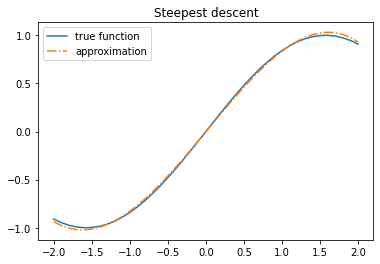

------------------------------------------------
	Algorithm 'Newthon method':
------------------------------------------------
Search terminated after iteration 1 with result: [[ 2.65168425e-05]
 [ 9.99048666e-01]
 [-9.37431166e-05]
 [-1.64457869e-01]
 [ 2.32282777e-05]
 [ 7.10869115e-03]]
Last gradient norm: 6.083285306186697e-14


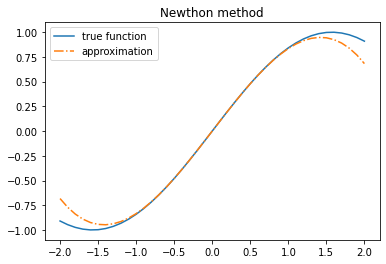

------------------------------------------------
	Algorithm 'Fletcher Reeves':
------------------------------------------------
Search terminated after iteration 753 with result: [[ 2.65161107e-05]
 [ 9.99048644e-01]
 [-9.37326304e-05]
 [-1.64457855e-01]
 [ 2.32267420e-05]
 [ 7.10868924e-03]]
Last gradient norm: 6.947111242572498e-06


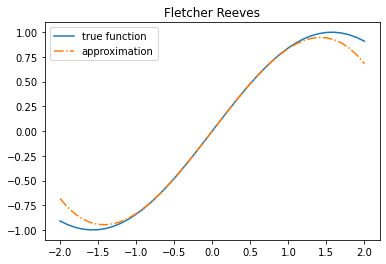

------------------------------------------------
	Algorithm 'SR1':
------------------------------------------------
Search terminated after iteration 29 with result: [[ 2.65159562e-05]
 [ 9.99048666e-01]
 [-9.37416840e-05]
 [-1.64457868e-01]
 [ 2.32279279e-05]
 [ 7.10869111e-03]]
Last gradient norm: 1.6004071194626597e-08


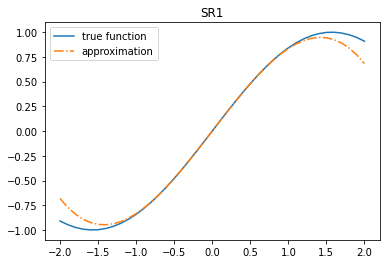

**********************************************
Problem CosinusSQEP:
**********************************************
------------------------------------------------
	Algorithm 'Steepest descent':
------------------------------------------------
Search terminated after iteration 5001 with result: [[ 9.97576580e-01]
 [ 1.08945293e-03]
 [-4.89818841e-01]
 [-1.13555030e-03]
 [ 3.43508422e-02]
 [ 2.48117850e-04]]
Last gradient norm: 0.06354916465026543


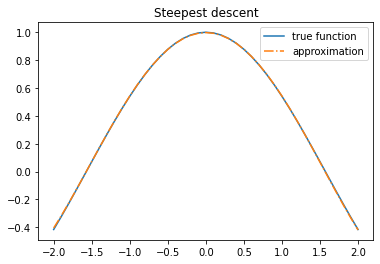

------------------------------------------------
	Algorithm 'Newthon method':
------------------------------------------------
Search terminated after iteration 1 with result: [[ 9.97858922e-01]
 [ 6.76963251e-04]
 [-4.90300157e-01]
 [-7.29472083e-04]
 [ 3.44718007e-02]
 [ 1.60330014e-04]]
Last gradient norm: 7.128679149472934e-14


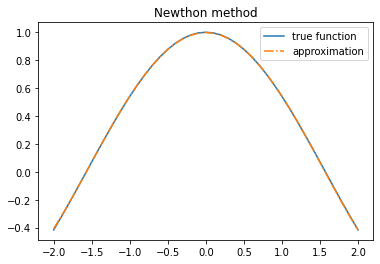

------------------------------------------------
	Algorithm 'Fletcher Reeves':
------------------------------------------------
Search terminated after iteration 2442 with result: [[ 9.97858917e-01]
 [ 6.76965396e-04]
 [-4.90300159e-01]
 [-7.29469672e-04]
 [ 3.44718020e-02]
 [ 1.60329096e-04]]
Last gradient norm: 5.822875003556655e-07


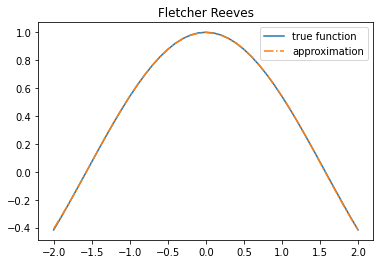

------------------------------------------------
	Algorithm 'SR1':
------------------------------------------------
Search terminated after iteration 27 with result: [[ 9.97858922e-01]
 [ 6.76963878e-04]
 [-4.90300156e-01]
 [-7.29472716e-04]
 [ 3.44718007e-02]
 [ 1.60330144e-04]]
Last gradient norm: 5.615502624075799e-09


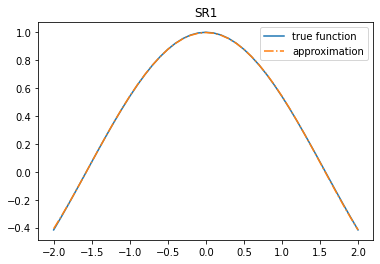

**********************************************
Problem SinusMinusCosinusSQEP:
**********************************************
------------------------------------------------
	Algorithm 'Steepest descent':
------------------------------------------------
Search terminated after iteration 5001 with result: [[-0.99501551]
 [ 0.97002054]
 [ 0.48438263]
 [-0.13608196]
 [-0.03251941]
 [ 0.00130079]]
Last gradient norm: 0.7070379419924163


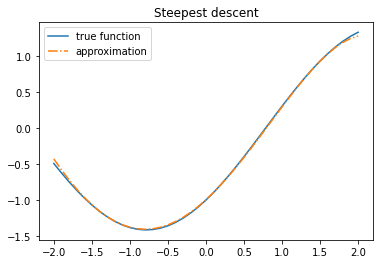

------------------------------------------------
	Algorithm 'Newthon method':
------------------------------------------------
Search terminated after iteration 1 with result: [[-0.99856365]
 [ 0.99958365]
 [ 0.49162964]
 [-0.16558059]
 [-0.03492333]
 [ 0.00747465]]
Last gradient norm: 1.9185773311665375e-13


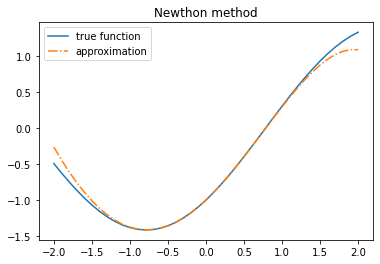

------------------------------------------------
	Algorithm 'Fletcher Reeves':
------------------------------------------------
Search terminated after iteration 1381 with result: [[-0.99856365]
 [ 0.99958362]
 [ 0.49162966]
 [-0.1655806 ]
 [-0.03492334]
 [ 0.00747466]]
Last gradient norm: 5.680210683109809e-06


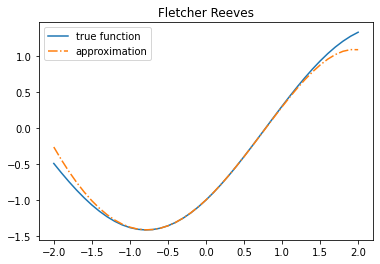

------------------------------------------------
	Algorithm 'SR1':
------------------------------------------------
Search terminated after iteration 9 with result: [[-0.99856365]
 [ 0.99958365]
 [ 0.49162964]
 [-0.16558059]
 [-0.03492333]
 [ 0.00747465]]
Last gradient norm: 9.127668058005299e-11


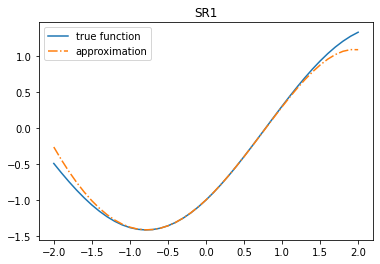

**********************************************
Problem CubePlusSquareSQEP:
**********************************************
------------------------------------------------
	Algorithm 'Steepest descent':
------------------------------------------------
Search terminated after iteration 5001 with result: [[-3.91486013e-04]
 [ 2.50895185e-02]
 [ 9.99843805e-01]
 [ 9.72998679e-01]
 [ 2.94806538e-04]
 [ 5.96040406e-03]]
Last gradient norm: 0.733434705949439


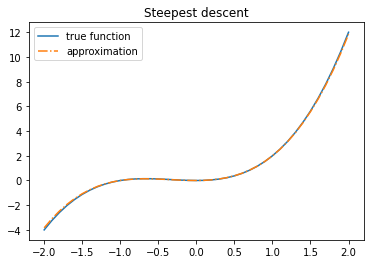

------------------------------------------------
	Algorithm 'Newthon method':
------------------------------------------------
Search terminated after iteration 1 with result: [[ 2.37411520e-14]
 [-1.04439880e-13]
 [ 1.00000000e+00]
 [ 1.00000000e+00]
 [ 1.33578895e-14]
 [-2.46315454e-14]]
Last gradient norm: 8.641153026418946e-13


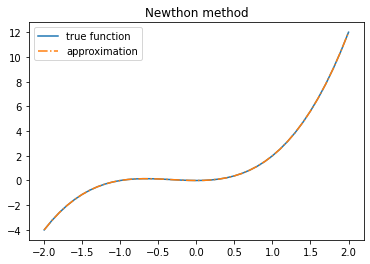

------------------------------------------------
	Algorithm 'Fletcher Reeves':
------------------------------------------------
Search terminated after iteration 683 with result: [[ 3.10154794e-08]
 [-3.45031319e-09]
 [ 1.00000001e+00]
 [ 1.00000001e+00]
 [ 2.68322145e-09]
 [-6.01945198e-10]]
Last gradient norm: 2.5952212124195008e-05


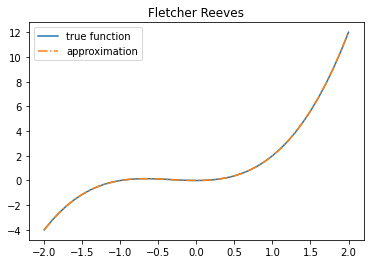

------------------------------------------------
	Algorithm 'SR1':
------------------------------------------------
Search terminated after iteration 9 with result: [[ 3.05483570e-09]
 [-2.03649317e-08]
 [ 9.99999994e-01]
 [ 1.00000002e+00]
 [ 1.34127492e-09]
 [-4.73578200e-09]]
Last gradient norm: 1.0881814939403999e-07


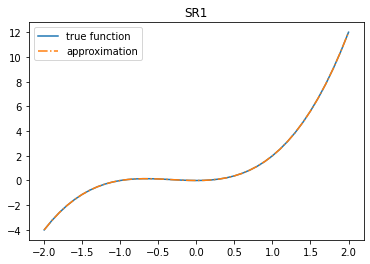

**********************************************
Problem SinusPlusCosinusSQEP:
**********************************************
------------------------------------------------
	Algorithm 'Steepest descent':
------------------------------------------------
Search terminated after iteration 5001 with result: [[ 1.00353102]
 [ 2.93742004]
 [-0.50299033]
 [-0.42958929]
 [ 0.03790587]
 [ 0.00805929]]
Last gradient norm: 1.7854400884141146


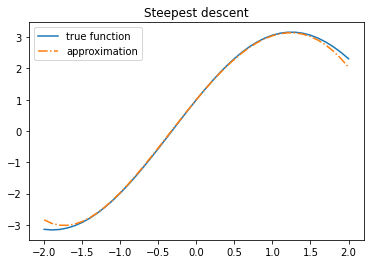

------------------------------------------------
	Algorithm 'Newthon method':
------------------------------------------------
Search terminated after iteration 1 with result: [[ 0.99847352]
 [ 2.99771762]
 [-0.49161353]
 [-0.49406803]
 [ 0.0347937 ]
 [ 0.02146873]]
Last gradient norm: 7.91942634110047e-13


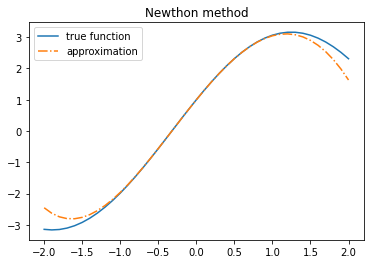

------------------------------------------------
	Algorithm 'Fletcher Reeves':
------------------------------------------------
Search terminated after iteration 600 with result: [[ 0.99847352]
 [ 2.9977176 ]
 [-0.49161354]
 [-0.49406803]
 [ 0.03479371]
 [ 0.02146873]]
Last gradient norm: 1.4027839391549633e-05


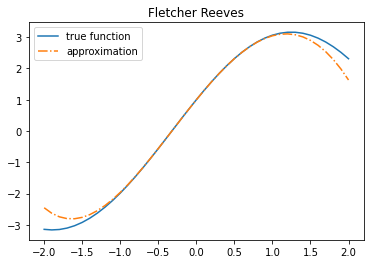

------------------------------------------------
	Algorithm 'SR1':
------------------------------------------------
Search terminated after iteration 9 with result: [[ 0.99847352]
 [ 2.99771762]
 [-0.49161353]
 [-0.49406803]
 [ 0.0347937 ]
 [ 0.02146873]]
Last gradient norm: 1.3797217505263784e-12


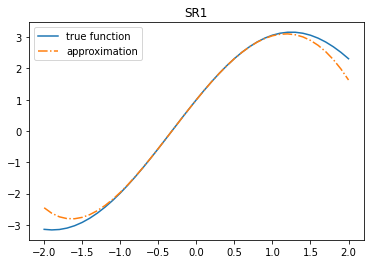

In [18]:
sqep_problems = {SinusSQEP: {'q': 2, 'num_points': 100, 'degree': 5},
                 CosinusSQEP: {'q': 2, 'num_points': 100, 'degree': 5},
                 SinusMinusCosinusSQEP: {'q': 2, 'num_points': 100, 'degree': 5},
                 CubePlusSquareSQEP: {'q': 2, 'num_points': 100, 'degree': 5},
                 SinusPlusCosinusSQEP: {'q': 2, 'num_points': 100, 'degree': 5}}

for prob_class, prob_params in sqep_problems.items():

    prob = prob_class(**prob_params)

    prob_num_points = prob_params['num_points']
    prob_q = prob_params['q']
    prob_degree = prob_params['degree']

    x_plot = [i / 10 for i in range(-prob_q * 10, prob_q * 10 + 1)]
    y_true_plot = [prob.target_function(x) for x in x_plot]

    print("**********************************************")
    print(f"Problem {type(prob).__name__}:")
    print("**********************************************")
    for algorithm_name, algorithm in algorithms_rosenbrock.items():
        try:
            print("------------------------------------------------")
            print(f"\tAlgorithm '{algorithm_name}':")
            print("------------------------------------------------")

            parameters = {'x0': np.reshape([0 for i in range(prob_degree + 1)], (prob_degree + 1, 1)),
                          'f': prob.f,
                          'grad_f': prob.grad_f,
                          'hessian_f': prob.hessian}

            # clean up parameters for generic method call
            possible_parameters = algorithm.__code__.co_varnames
            for p in list(parameters):
                if p not in possible_parameters:
                    parameters.pop(p)

            coef, iterations = algorithm(**parameters)
            print(f"Search terminated after iteration {iterations} with result: {coef}")
            print(f"Last gradient norm: {norm(prob.grad_f(coef))}")

            approximation_y = []
            for i in range(len(x_plot)):
                approximation_y.append(0)
                for d in range(prob_degree):
                    approximation_y[i] += coef[d] * x_plot[i] ** d

            plt.plot(x_plot, y_true_plot, label="true function")
            plt.plot(x_plot, approximation_y, '-.', label="approximation")
            plt.title(f'{algorithm_name}')
            plt.legend()
            plt.show()

        except Exception as err:
            print(err)
            print(f"Algorithm '{algorithm_name}' failed to find a solution.")